In [1]:
# importing necessary packages for the section
import os
from os.path import isfile, join
import IPython
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from scipy.io import wavfile
from scipy.fft import fft, fftfreq
from scipy.signal import spectrogram, find_peaks
import sklearn
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
# from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from scipy.io.wavfile import read
import wave

print('The scikit-learn version is {}.'.format(sklearn.__version__))

sns.set()

The scikit-learn version is 1.2.2.


# Exploration analysis

## About the dataset

- Files contain audio of individual chords in `.wav` format.
- Chords are divided into two categories: **Major** a **Minor**.
- Some chords are produced by guitar some by piano.

The task is to classify chords by its parameters to **Major** and **Minor**.

## Transformation from audio to suitable format

## Transformation of audia into numbers

In [2]:
def audio_to_num(path_file):
  sample_rate, raw_signal = wavfile.read(path_file)
  raw_signal = raw_signal.astype('float32')
  #raw_signal /= np.max(np.abs(raw_signal), axis=0)  # Normalize sample

  print(f'signal_wave: {raw_signal[:10]}')
  print(f'shape signal_wave: {raw_signal.shape}')
  print(f'sample_rate: {sample_rate}')
  return sample_rate, raw_signal 

In [4]:
fs_major, raw_major = audio_to_num("./Audio_Files/Major/Major_0.wav")
fs_minor, raw_minor = audio_to_num("./Audio_Files/Minor/Minor_0.wav")
raw_major_pandas = pd.Series(raw_major).to_frame().reset_index().rename(columns={'index':'time'})
raw_major_pandas['time'] /= fs_major
raw_minor_pandas = pd.Series(raw_minor).to_frame().reset_index().rename(columns={'index':'time'})
raw_minor_pandas['time'] /= fs_minor
raw_major_pandas

signal_wave: [-142. -193. -158. -180. -179. -166. -180. -179. -180. -189.]
shape signal_wave: (99225,)
sample_rate: 44100
signal_wave: [-142. -193. -158. -180. -179. -166. -180. -179. -180. -189.]
shape signal_wave: (99225,)
sample_rate: 44100


time      0
0      0.000000 -142.0
1      0.000023 -193.0
2      0.000045 -158.0
3      0.000068 -180.0
4      0.000091 -179.0
...         ...    ...
99220  2.249887    0.0
99221  2.249909    0.0
99222  2.249932    0.0
99223  2.249955    0.0
99224  2.249977    0.0

[99225 rows x 2 columns]

## Visualization of raw data

In [5]:
def raw_audio_plot(raw_audio_pandas):
  raw_audio_pandas.set_index('time')[0].plot(figsize=(15, 5),
                  lw=1,
                  title='Raw Audio')
  plt.xlabel = 'Time [sec]'
  plt.show()

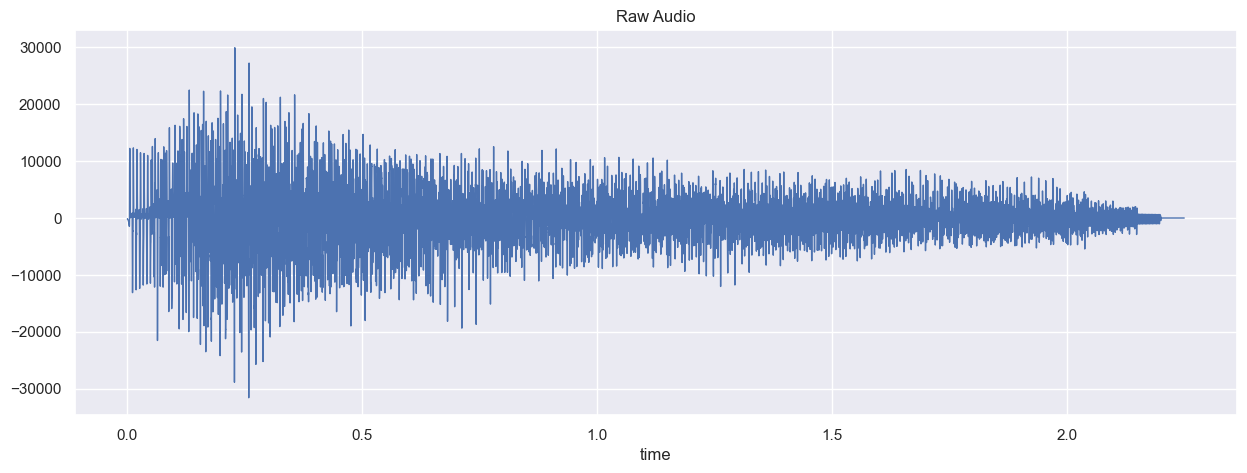

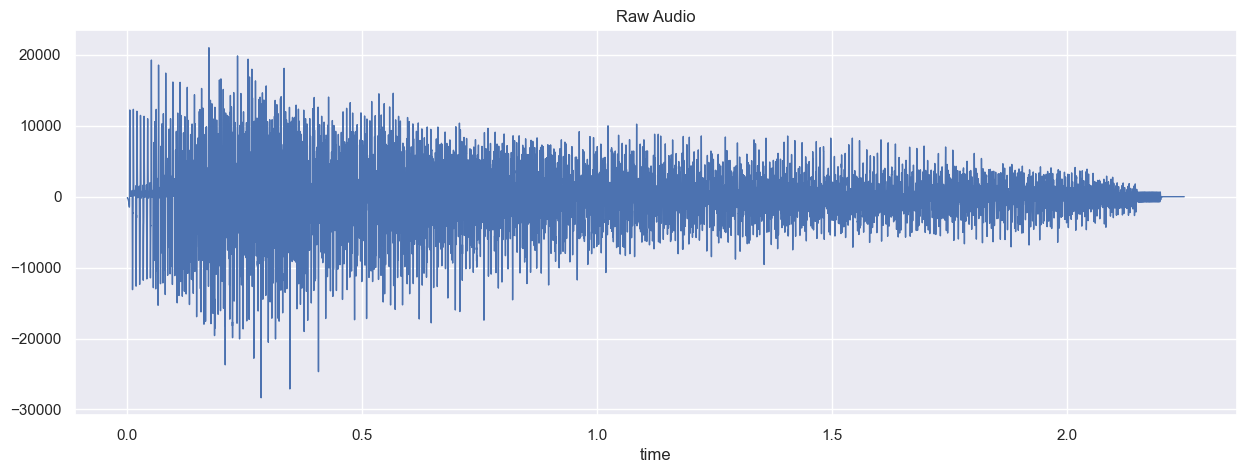

In [6]:
raw_audio_plot(raw_major_pandas)
raw_audio_plot(raw_minor_pandas)

In [7]:
def raw_detail_plot(raw_audio_pandas):
  (raw_audio_pandas[30000:30500]).set_index('time')[0].plot(figsize=(15, 5),
                  lw=1,
                  title='Raw Audio Zoomed')
  plt.xlabel = 'Time [sec]'
  plt.show()

In [8]:
raw_detail_plot(raw_major_pandas)
raw_detail_plot(raw_minor_pandas)

## Spectogram

A spectrogram is a visual representation of the spectrum of frequencies of a signal as it varies with time.

In [65]:
# Spectogram
from scipy.signal import spectrogram

path = "Audio_Files/Major/Major_0.wav"
fs, signal = wavfile.read(path)
f, t, Sxx = spectrogram(signal, fs, nperseg=2500, nfft = 50000)

# Plots
fig, axes = plt.subplots(1, 2, figsize=(16, 12))
axes[0].pcolormesh(t, f, np.log(Sxx), cmap="jet")
axes[0].set_title("Spectogram (No Zoom)")
axes[0].set(xlabel='Time [sec]', ylabel='Frequency [Hz]')
axes[1].pcolormesh(t, f[:1500], np.log(Sxx)[:1500,:], cmap="jet")
axes[1].set_title("Spectogram (Zoomed)")
axes[1].set(xlabel='Time [sec]', ylabel='Frequency [Hz]')
plt.show()

## Visualizing audio data before and after fourier transform

In [10]:
# fourier transform function modified for easy usage
def custom_fft(raw, fs=44100):
    N = len(raw)
    # compute fourier transform with scipy functions
    X_f = fft(raw)
    freqs = fftfreq(N, 1/fs)

    # take only the positive terms
    X_f = X_f[:N//2]
    freqs = freqs[:N//2]
    # we dont really care about the imaginary output,
    # so we just that the distance of the vector
    vals = np.abs(X_f)
    return freqs, vals

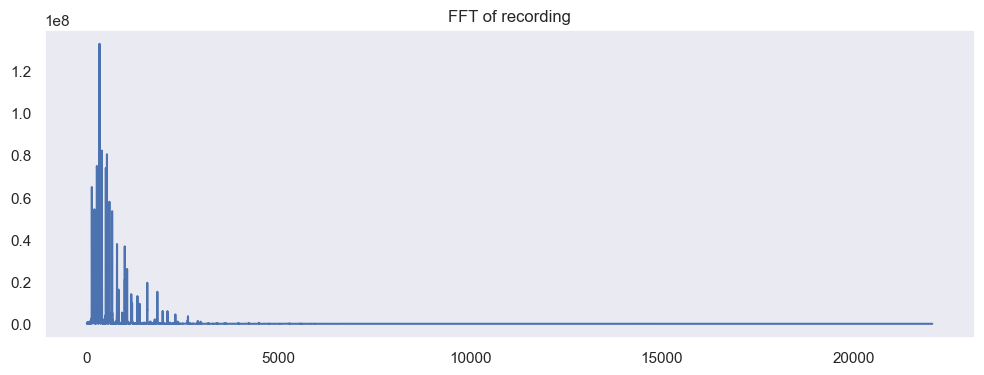

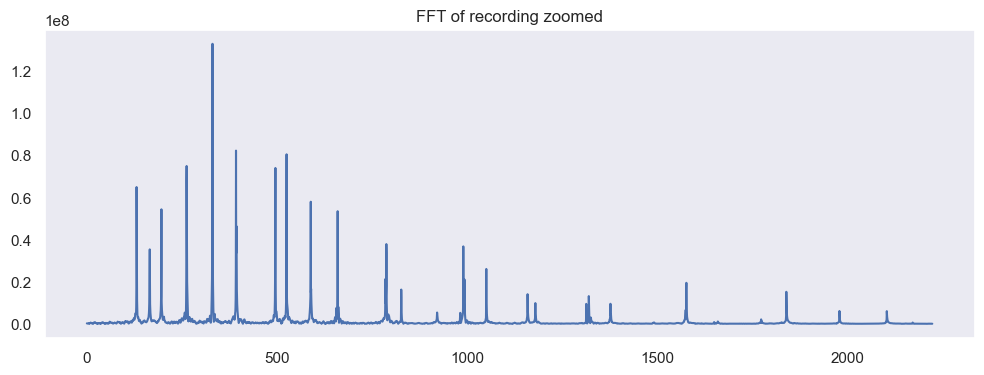

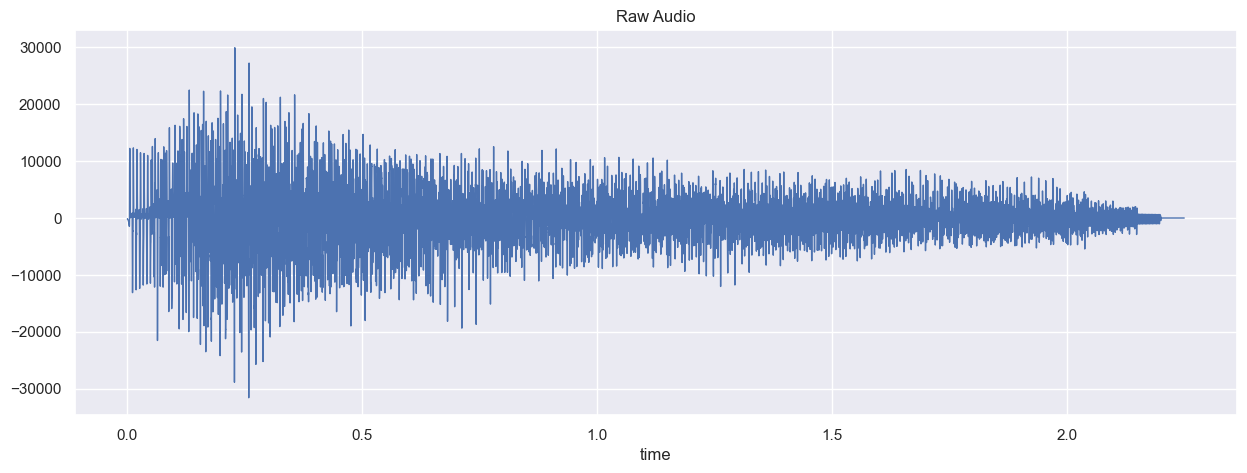

In [11]:
xf, vals = custom_fft(raw_major, fs_major)
plt.figure(figsize=(12, 4))
plt.title('FFT of recording')
plt.plot(xf, vals)
plt.xlabel = 'Frequency [Hz]'
plt.grid()
plt.show()

plt.figure(figsize=(12, 4))
plt.title('FFT of recording zoomed')
plt.plot(xf[:5000], vals[:5000])
plt.xlabel = 'Frequency [Hz]'
plt.grid()
plt.show()

raw_audio_plot(raw_major_pandas)
raw_detail_plot(raw_major_pandas)

In [12]:
# Function that essentially transforms the audio file to harmonics (dominant frequencies)
def find_harmonics(path, print_peaks=False):
    fs, X = wavfile.read(path)
    freqs, X_f = custom_fft(X, fs)

    # we've found out that frequencies under 50 can make some mess in the 
    # dataset
    freqs_50_index = np.abs(freqs - 50).argmin()
    
    # min height is 5% of the tallest frequence
    h = X_f.max() * 0.05
    # find peaks
    peaks, _ = find_peaks(X_f, distance=10, height = h)
    peaks = peaks[peaks>freqs_50_index]
    harmonics = np.round(freqs[peaks],2)
    
    if print_peaks:
        i = peaks.max() + 100
        plt.figure(figsize=(16,8))
        plt.plot(freqs[:i], X_f[:i])
        plt.plot(freqs[peaks], X_f[peaks], "x")
        plt.plot(freqs[:i], list(map(lambda x: h, freqs[:i])))
        plt.xlabel = 'Frequency [Hz]'
        plt.show()
    return harmonics

## Creating a dataframe we can further work with

In [13]:
def create_df():
  path = "Audio_Files"
  max_harmonics = 0

  data = []


  for dirname, _, filenames in os.walk(path):
      for filename in filenames:
          row = [dirname.split('/')[-1], filename]
          freq_peaks = find_harmonics(join(dirname, filename))
          max_harmonics = max(max_harmonics, len(freq_peaks))

          row.append(len(freq_peaks))
          row.extend(freq_peaks)
          data.append(row)
        
  columns = ["type", "filename", "harmonics-count"]
  for i in range(max_harmonics):
    columns.append("harmonic-{}".format(i))

  df = pd.DataFrame(data, columns=columns)
  return df


df = create_df()
df

type       filename  harmonics-count  harmonic-0  \
0    Audio_Files\Major    Major_0.wav               21      130.67   
1    Audio_Files\Major    Major_1.wav               16      131.11   
2    Audio_Files\Major   Major_10.wav               20      130.91   
3    Audio_Files\Major  Major_100.wav               27      155.45   
4    Audio_Files\Major  Major_101.wav               20      155.91   
..                 ...            ...              ...         ...   
854  Audio_Files\Minor   Minor_95.wav               17       83.04   
855  Audio_Files\Minor   Minor_96.wav               35       82.61   
856  Audio_Files\Minor   Minor_97.wav               17       83.04   
857  Audio_Files\Minor   Minor_98.wav               20      165.45   
858  Audio_Files\Minor   Minor_99.wav               12      165.00   

     harmonic-1  harmonic-2  harmonic-3  harmonic-4  harmonic-5  harmonic-6  \
0        165.33      196.00      262.22      330.22      392.00      495.56   
1        165.33      174.67      196.44      261.78      266.67      331.11   
2        185.00      234.09      262.27      329.55      370.45      393.18   
3        195.91      278.18      311.36      349.55      392.27      466.82   
4        175.45      196.82      273.18      278.18      283.18      311.36   
..          ...         ...         ...         ...         ...         ...   
854      146.96      165.22      196.52      220.44      246.96      293.48   
855      123.91      146.52      165.22      196.09      247.83      278.26   
856      146.96      165.22      196.52      246.96      278.26      293.48   
857      234.09      325.00      330.45      391.82      468.18      495.45   
858      233.18      324.55      330.91      340.00      392.73      466.36   

     ...  harmonic-28  harmonic-29  harmonic-30  harmonic-31  harmonic-32  \
0    ...          NaN          NaN          NaN          NaN          NaN   
1    ...          NaN          NaN          NaN          NaN          NaN   
2    ...          NaN          NaN          NaN          NaN          NaN   
3    ...          NaN          NaN          NaN          NaN          NaN   
4    ...          NaN          NaN          NaN          NaN          NaN   
..   ...          ...          ...          ...          ...          ...   
854  ...          NaN          NaN          NaN          NaN          NaN   
855  ...      1178.71       1376.1      1391.75      1670.45      1853.06   
856  ...          NaN          NaN          NaN          NaN          NaN   
857  ...          NaN          NaN          NaN          NaN          NaN   
858  ...          NaN          NaN          NaN          NaN          NaN   

     harmonic-33  harmonic-34  harmonic-35  harmonic-36  harmonic-37  
0            NaN          NaN          NaN          NaN          NaN  
1            NaN          NaN          NaN          NaN          NaN  
2            NaN          NaN          NaN          NaN          NaN  
3            NaN          NaN          NaN          NaN          NaN  
4            NaN          NaN          NaN          NaN          NaN  
..           ...          ...          ...          ...          ...  
854          NaN          NaN          NaN          NaN          NaN  
855      1949.15      2224.37          NaN          NaN          NaN  
856          NaN          NaN          NaN          NaN          NaN  
857          NaN          NaN          NaN          NaN          NaN  
858          NaN          NaN          NaN          NaN          NaN  

[859 rows x 41 columns]

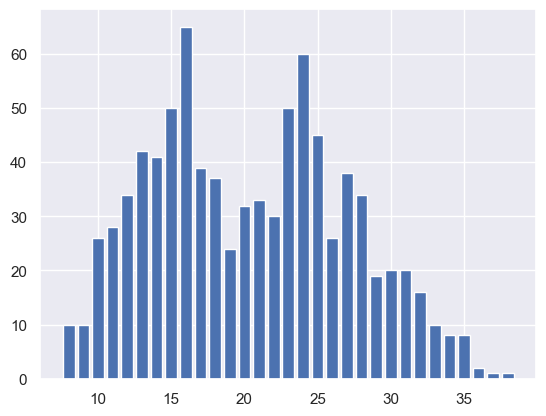

count    859.000000
mean      20.389988
std        6.656608
min        8.000000
25%       15.000000
50%       20.000000
75%       25.000000
max       38.000000
Name: harmonics-count, dtype: float64

In [14]:
plt.bar(sorted(df['harmonics-count'].unique()), df['harmonics-count'].value_counts().sort_index())
plt.show() # maybe the last X harmonics are not as importnant and should be removed
df['harmonics-count'].describe()

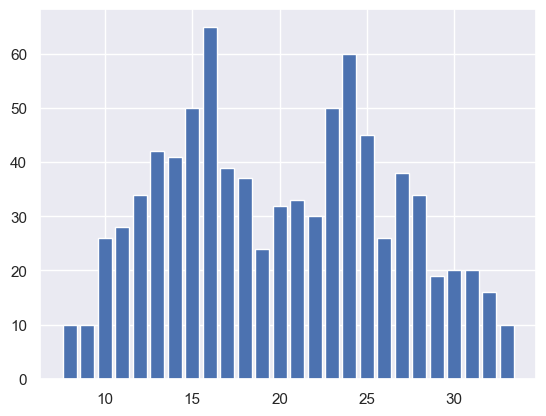

count    839.000000
mean      20.042908
std        6.337227
min        8.000000
25%       15.000000
50%       20.000000
75%       25.000000
max       33.000000
Name: harmonics-count, dtype: float64

In [15]:
df_droped = df.drop(df.loc[df['harmonics-count']>=34].index, inplace=False)
plt.bar(sorted(df_droped['harmonics-count'].unique()), (df_droped['harmonics-count'].value_counts().sort_index()))

plt.show() # the last X harmonics removed
df_droped['harmonics-count'].describe()


In [22]:
# plot 20 vals
def plots_20(df, col_name):
  fig, axes = plt.subplots(5, 4, figsize=(18, 10))
  for i in range(0,20):
      plt.subplot(5, 4, i+1)
      sns.kdeplot(data=df, x=(col_name + "-{}".format(i)), hue="type", fill=True)
  fig.tight_layout()
  plt.show()


plots_20(df, 'harmonic')

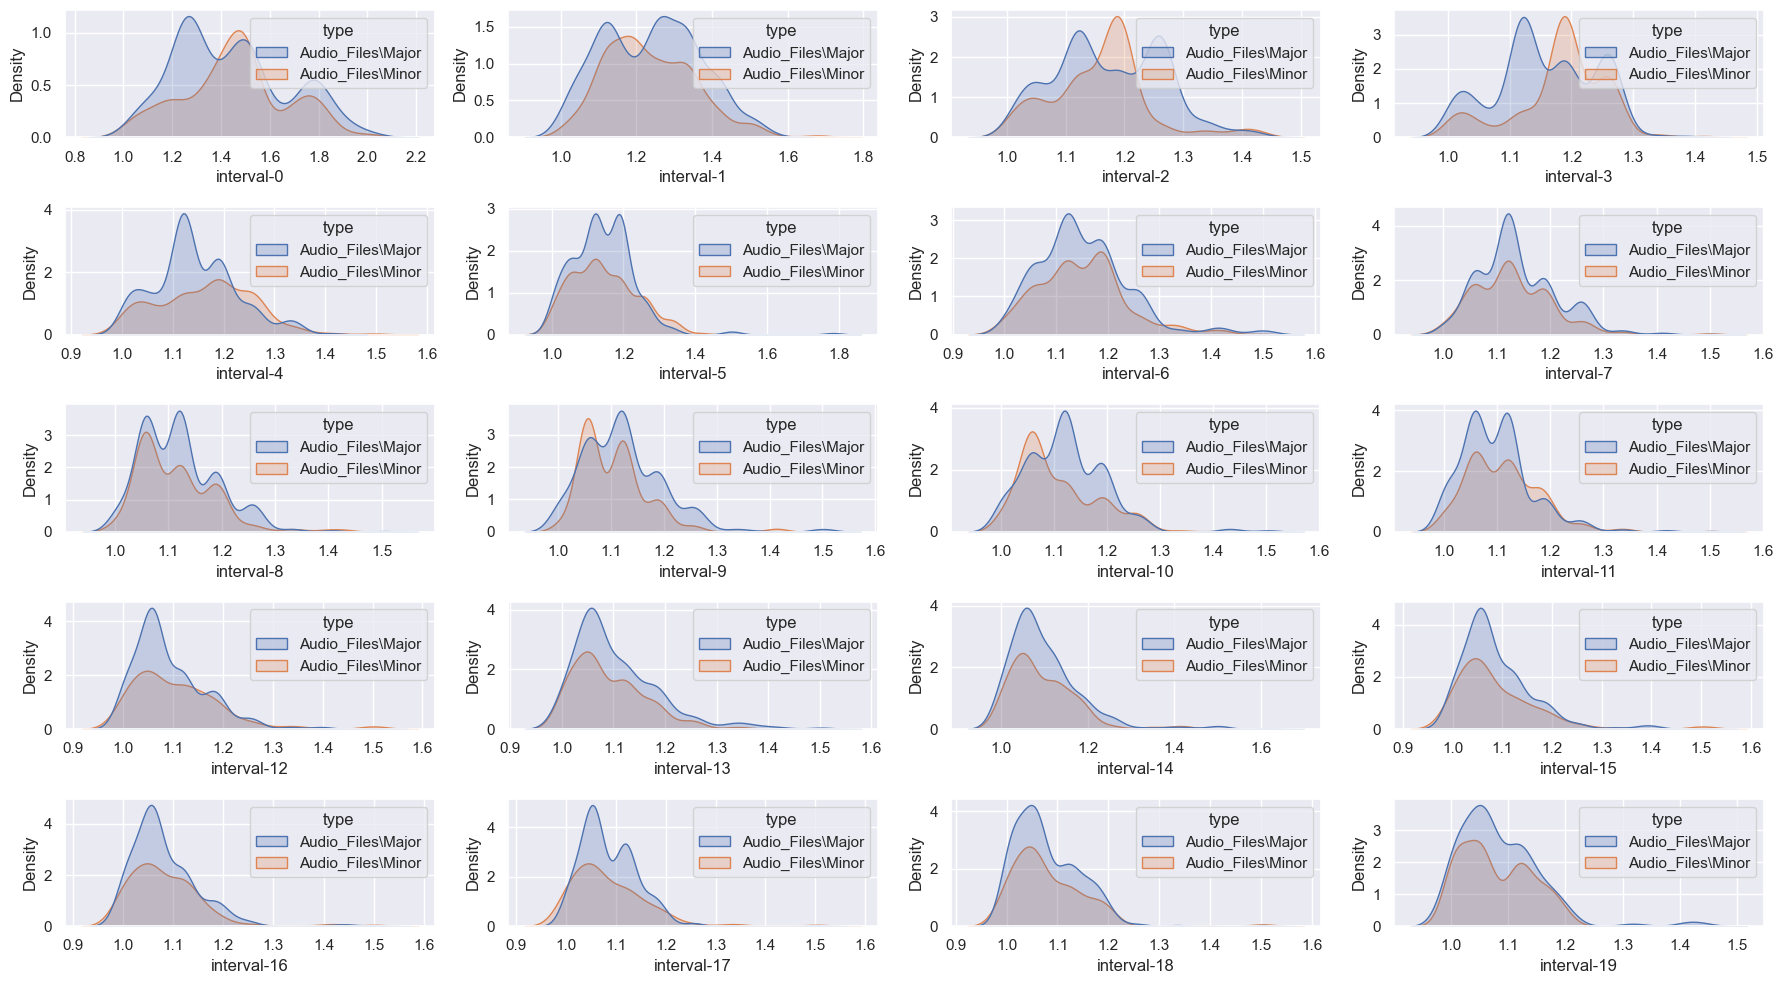

In [23]:
intervals = df.copy()

for i in range(0, 20):
  interval = 'interval-{}'.format(i)
  curr_harm = f'harmonic-{i+1}'
  prev_harm = f'harmonic-{i}'
  intervals[interval] = intervals[curr_harm].div(intervals[prev_harm], axis=0)

plots_20(intervals, 'interval')

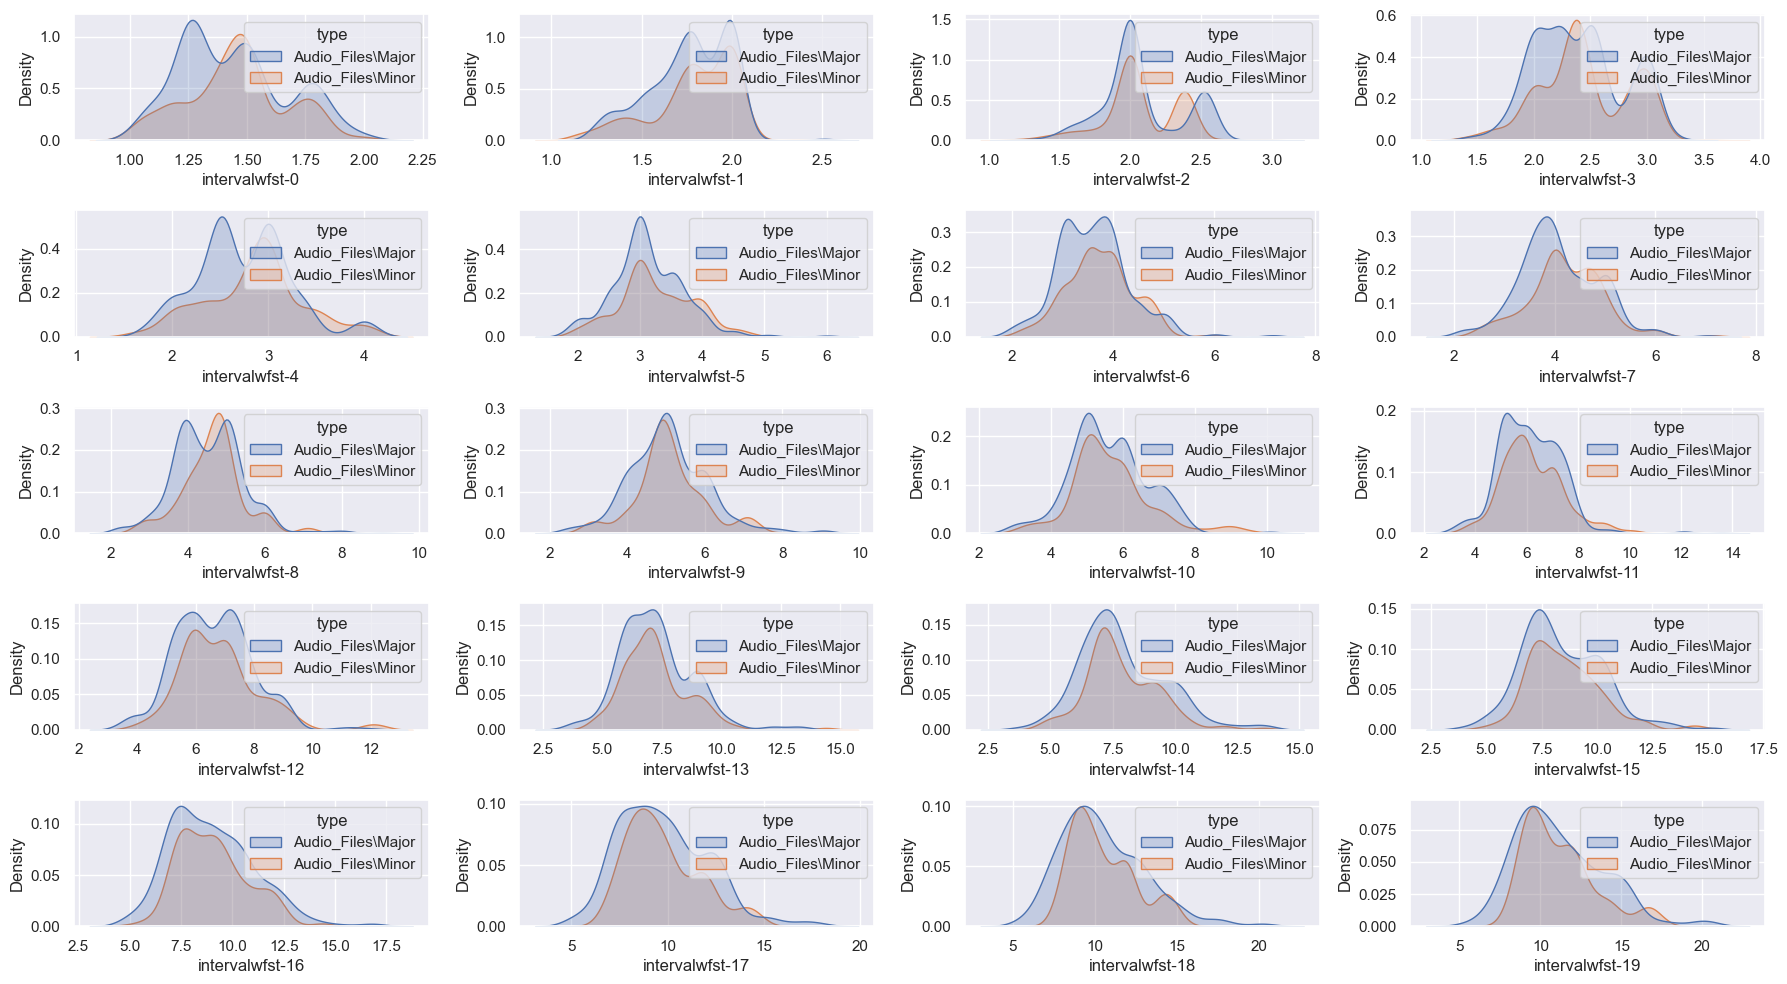

In [24]:
intervals = df.copy()

for i in range(0, 20):
  interval = 'intervalwfst-{}'.format(i)
  curr_harm = f'harmonic-{i+1}'
  prev_harm = 'harmonic-0'
  intervals[interval] = intervals[curr_harm].div(intervals[prev_harm], axis=0)

plots_20(intervals, 'intervalwfst')

- intervalwfst-2 -> interval between 4th and 1st
- intervalwfst-3 -> interval between 5th and 1st
- intervalwfst-4 -> interval between 6th and 1st
- maybe even intervalwfst-8 -> interval between 10th and 1st

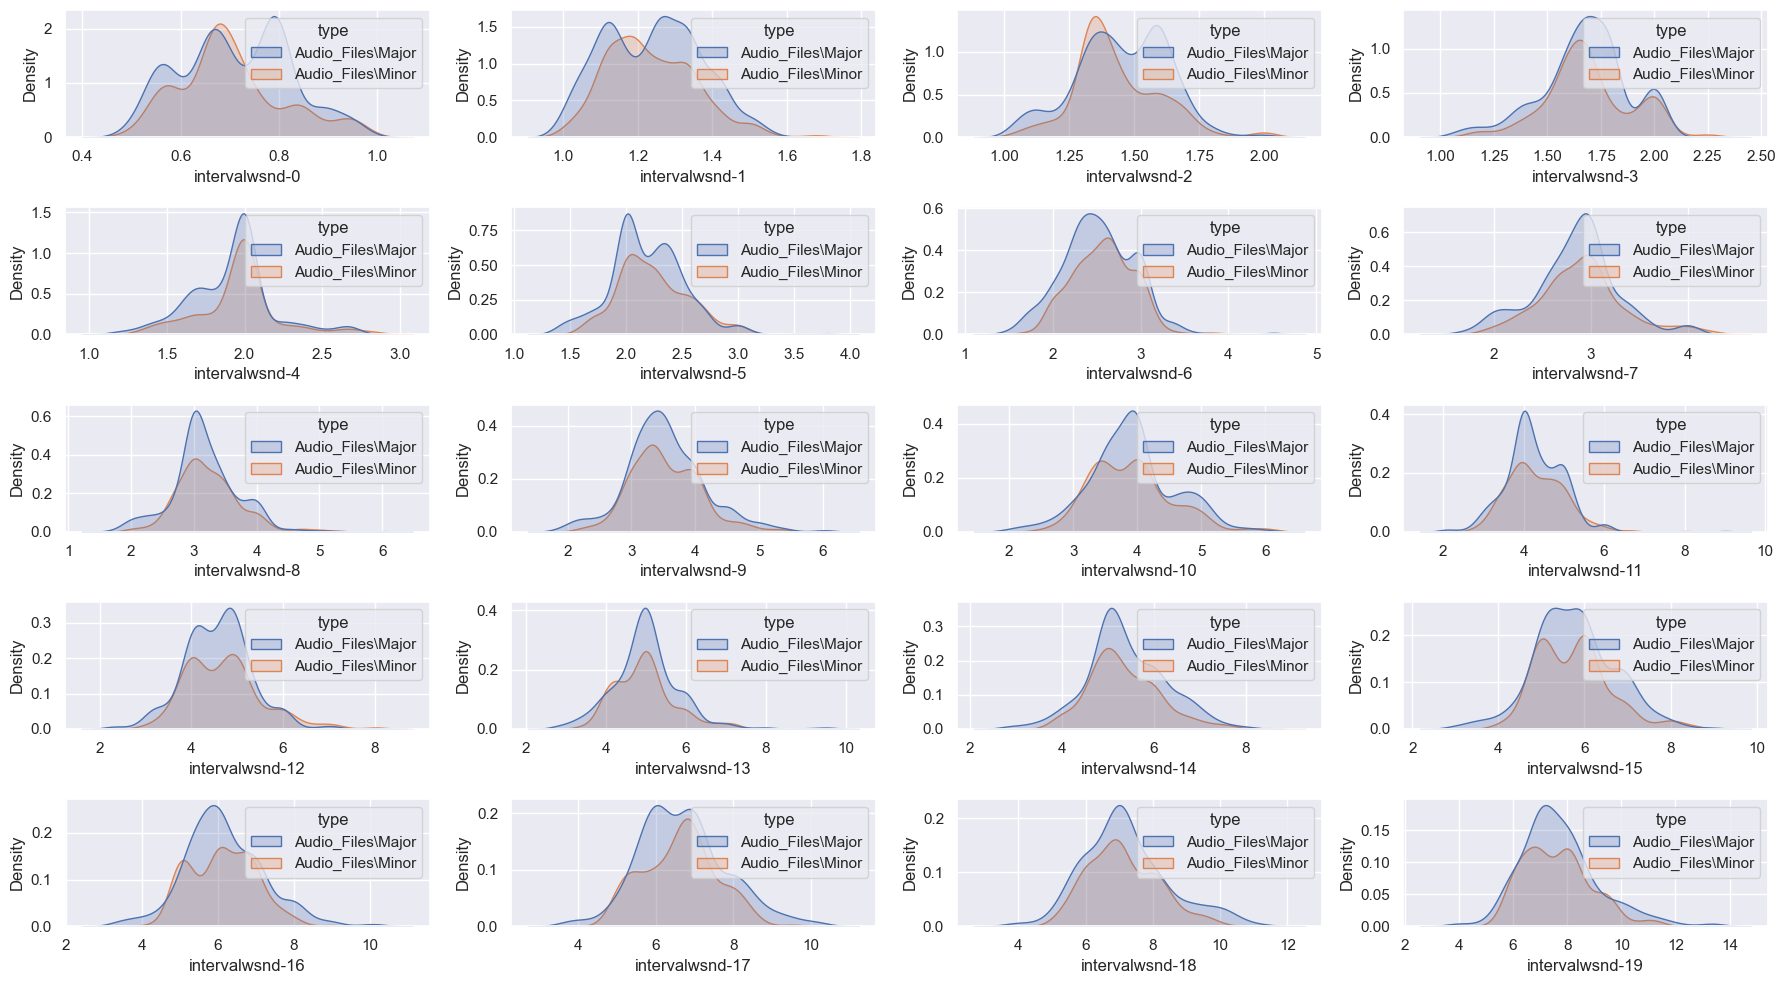

In [25]:
intervals = df.copy()

for i in range(0, 20):
  interval = 'intervalwsnd-{}'.format(i)
  if i == 0:
    curr_harm = f'harmonic-{i}'
  else:
    curr_harm = f'harmonic-{i+1}'
  prev_harm = 'harmonic-1'
  intervals[interval] = intervals[curr_harm].div(intervals[prev_harm], axis=0)

plots_20(intervals, 'intervalwsnd')

- intervalwsnd-1 -> but we already saw that one -> between 3rd and 2nd
- **intervalwsnd-2** - between **4th and 2nd**

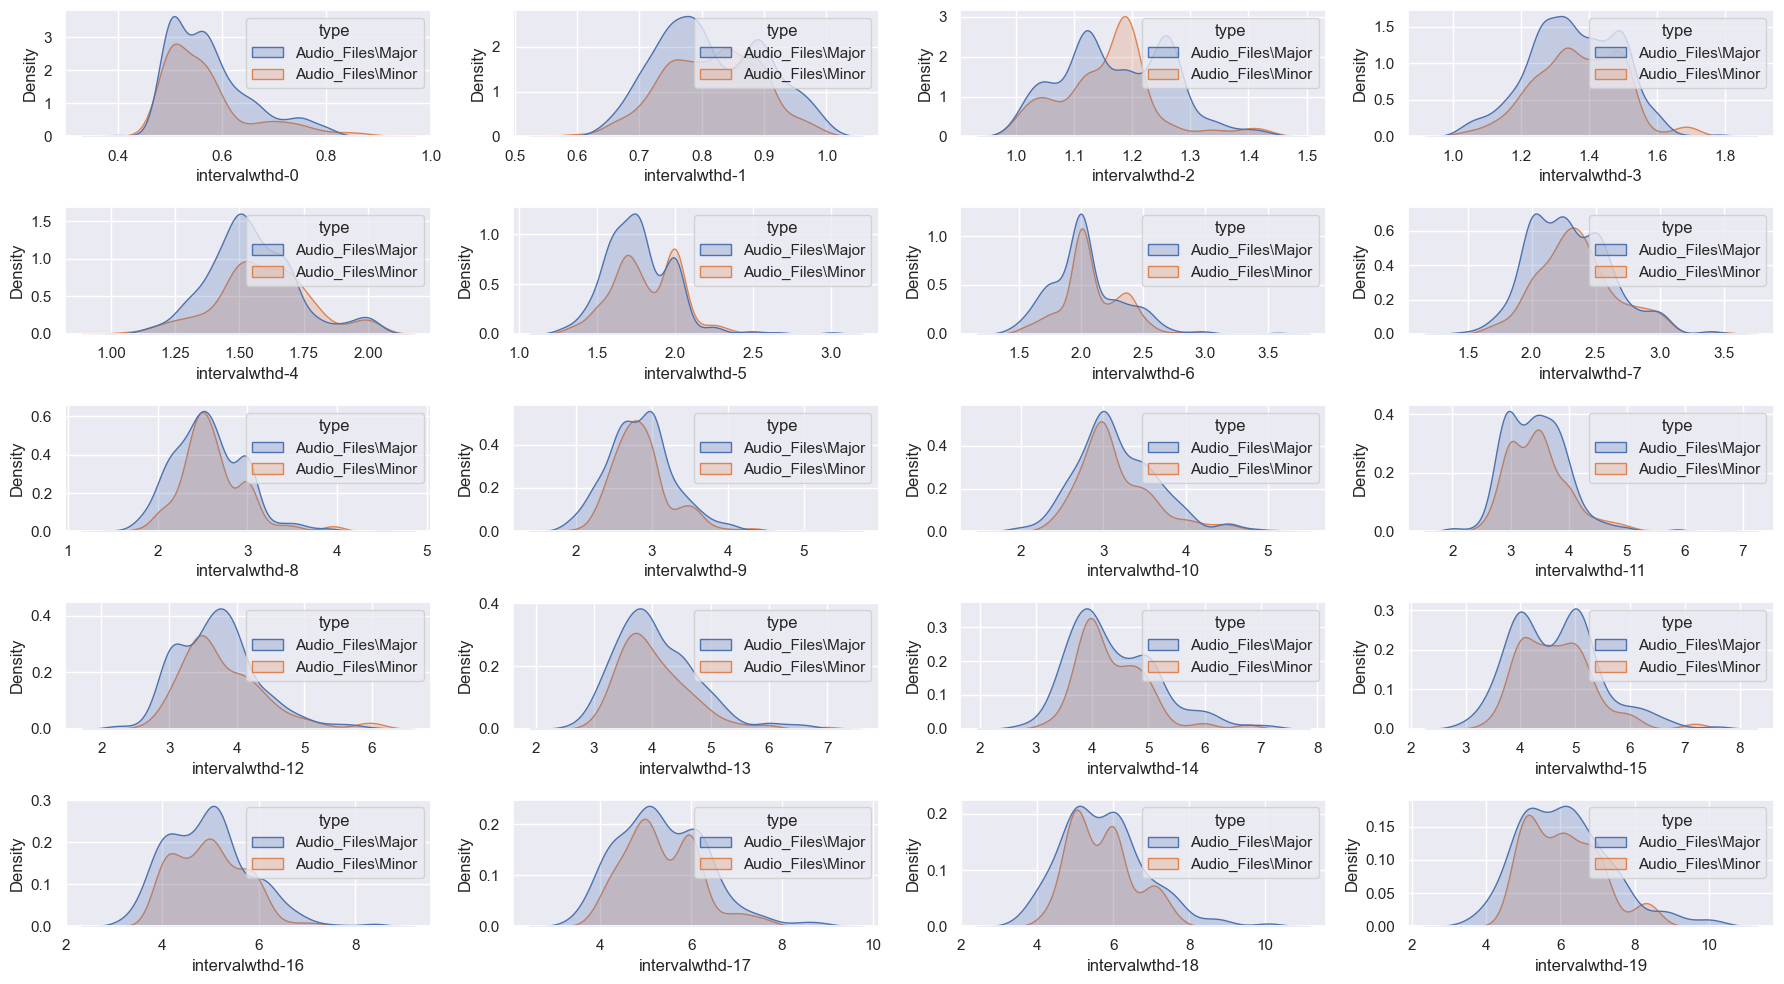

In [26]:
intervals = df.copy()

for i in range(0, 20):
  interval = 'intervalwthd-{}'.format(i)
  if i < 2:
    curr_harm = f'harmonic-{i}'
  else:
    curr_harm = f'harmonic-{i+1}'
  prev_harm = 'harmonic-2'
  intervals[interval] = intervals[curr_harm].div(intervals[prev_harm], axis=0)

plots_20(intervals, 'intervalwthd')

here it gets kind of useless

## interesing intervals:

we are indexing from `0`, so from now on intervals will be denoted like that.

- between **0 and 1**
- between **1 and 2**
- between **2 and 3**
- between **3 and 4**
- between **0 and 3**
- between **0 and 4**
- between **0 and 5**
- between **0 and 9** (?)
- between **1 and 3**

We will see if all of them are useful, or only a smaller subset (or maybe a bigger one).

# Preprocessing

In [45]:
from imblearn.over_sampling import RandomOverSampler, SMOTE

# This code of block is for generating the preprocessed data,
# basic usage is just:
# X_train, X_test, y_train, y_test = prepare_data()

def custom_fft(raw, fs=44100):
    N = len(raw)
    X_f = fft(raw)
    freqs = fftfreq(N, 1/fs)
    X_f = X_f[:N//2]
    freqs = freqs[:N//2]
    vals = np.abs(X_f)
    return freqs, vals

def find_harmonics(path, print_peaks=False):
    fs, X = wavfile.read(path)
    freqs, X_f = custom_fft(X, fs)
    freqs_50_index = np.abs(freqs - 50).argmin()
    h = X_f.max() * 0.05
    peaks, _ = find_peaks(X_f, distance=10, height = h)
    peaks = peaks[peaks>freqs_50_index]
    harmonics = np.round(freqs[peaks],2)
    if print_peaks:
        i = peaks.max() + 100
        plt.figure(figsize=(16,8))
        plt.plot(freqs[:i], X_f[:i])
        plt.plot(freqs[peaks], X_f[peaks], "x")
        plt.plot(freqs[:i], list(map(lambda x: h, freqs[:i])))
        plt.xlabel = 'Frequency [Hz]'
        plt.show()
    return harmonics

def create_df():
  path = "Audio_Files"
  max_harmonics = 0
  data = []
  for dirname, _, filenames in os.walk(path):
      for filename in filenames:
          row = [dirname.split('/')[-1], filename]
          freq_peaks = find_harmonics(join(dirname, filename))
          max_harmonics = max(max_harmonics, len(freq_peaks))
          row.append(len(freq_peaks))
          row.extend(freq_peaks)
          data.append(row)
  columns = ["type", "filename", "harmonics-count"]
  for i in range(max_harmonics):
    columns.append("harmonic-{}".format(i))
  df = pd.DataFrame(data, columns=columns)
  return df

def create_intervals():
  df = create_df()
  new_df = df.loc[:,('type', 'filename')]
  new_df['int-0-1'] = df['harmonic-1'] / df['harmonic-0']
  new_df['int-1-2'] = df['harmonic-2'] / df['harmonic-1']
  new_df['int-2-3'] = df['harmonic-3'] / df['harmonic-2']
  new_df['int-3-4'] = df['harmonic-4'] / df['harmonic-3']
  new_df['int-0-3'] = df['harmonic-3'] / df['harmonic-0']
  new_df['int-0-4'] = df['harmonic-4'] / df['harmonic-0']
  new_df['int-0-5'] = df['harmonic-5'] / df['harmonic-0']
  new_df['int-1-3'] = df['harmonic-3'] / df['harmonic-1']
  return new_df

def prepare_data():
  df = create_intervals()
  X = df.drop(columns=['type', 'filename'])
  X = X.fillna(0)
  y = df['type'].astype('category')
  y = y.apply(lambda x: 1 if x == 'Audio_Files\Major' else 0)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)
  smote = SMOTE()
  X_train, y_train = smote.fit_resample(X_train, y_train)
  return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = prepare_data()

# Models to use

- Naive bayes as a baseline
- KNN
- Decision Tree Classifier
- Random Forest Classifier
- SVM

# Evaluation of a model

In [46]:
# evaluation function
def eval_model(model, train, test, validation=None):
  X_train, y_train = train
  y_train_predicted = model.predict(X_train)
  print("accuracy on train -      {:.2f}".format(accuracy_score(y_train, y_train_predicted)))
  print("f1 score on train -      {:.2f}".format(f1_score(y_train, y_train_predicted)))
  cm = confusion_matrix(y_train, y_train_predicted)
  print("Confusion matrix on train:")
  print(cm)
  X_test, y_test = test
  if validation:
    X_validation, y_validation = validation
    y_val_predicted = model.predict(X_validation)
    print("accuracy on validation - {:.2f}".format(accuracy_score(y_validation, y_val_predicted)))
    print("f1 score on validation - {:.2f}".format(f1_score(y_validation, y_val_predicted)))
  y_test_predicted = model.predict(X_test)
  print("accuracy on test -       {:.2f}".format(accuracy_score(y_test, y_test_predicted)))
  print("f1 score on test -       {:.2f}".format(f1_score(y_test, y_test_predicted)))
  cm = confusion_matrix(y_test, y_test_predicted)
  print("Confusion matrix on test:")
  print(cm)

# Models

## Baseline

As a baseline we can also take the results from [this work](https://www.kaggle.com/code/ahmetcelik158/mathematics-of-music-chord-classification/notebook), where the best result was this:

```
Confusion Matrix:
[[121  12]
 [ 10 201]]
Accuracy Score: 0.94
```

trained model on 60% of dataset and tested on 40%, these are results on the test set.

In [47]:
nb = GaussianNB()
nb.fit(X_train, y_train)

eval_model(nb, (X_train, y_train), (X_test, y_test))

accuracy on train -      0.60
f1 score on train -      0.59
Confusion matrix on train:
[[197 107]
 [134 170]]
accuracy on test -       0.62
f1 score on test -       0.64
Confusion matrix on test:
[[ 94  52]
 [ 80 118]]


In [48]:
baseline_pipe = make_pipeline(StandardScaler(), GaussianNB())
baseline_pipe.fit(X_train, y_train)

eval_model(baseline_pipe, (X_train, y_train), (X_test, y_test))


accuracy on train -      0.60
f1 score on train -      0.59
Confusion matrix on train:
[[197 107]
 [134 170]]
accuracy on test -       0.62
f1 score on test -       0.64
Confusion matrix on test:
[[ 94  52]
 [ 80 118]]


## SVM

In [49]:
svm = SVC()

svm.fit(X_train, y_train)

eval_model(svm, (X_train, y_train), (X_test, y_test))

accuracy on train -      0.60
f1 score on train -      0.64
Confusion matrix on train:
[[153 151]
 [ 90 214]]
accuracy on test -       0.64
f1 score on test -       0.69
Confusion matrix on test:
[[ 81  65]
 [ 59 139]]


In [50]:
pip_svm = make_pipeline(StandardScaler(), SVC())

param_grid = {'svc__C': [0.001, 0.01, 0.1, 1, 10, 100], 'svc__gamma': ["scale", "auto"],
              'svc__kernel': ['rbf']}

grid_search_cv = GridSearchCV(pip_svm, param_grid, cv=5, scoring="f1", n_jobs=4, verbose=4)
grid_search_cv.fit(X_train, y_train)

print(grid_search_cv.best_params_)
best_svm = grid_search_cv.best_estimator_
eval_model(best_svm, (X_train, y_train), (X_test, y_test))



Fitting 5 folds for each of 12 candidates, totalling 60 fits
{'svc__C': 100, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}
accuracy on train -      0.96
f1 score on train -      0.96
Confusion matrix on train:
[[295   9]
 [ 13 291]]
accuracy on test -       0.87
f1 score on test -       0.88
Confusion matrix on test:
[[127  19]
 [ 27 171]]


## KNN

In [51]:
knn = KNeighborsClassifier()

knn.fit(X_train, y_train)

eval_model(knn, (X_train, y_train), (X_test, y_test))

accuracy on train -      0.90
f1 score on train -      0.89
Confusion matrix on train:
[[280  24]
 [ 39 265]]
accuracy on test -       0.81
f1 score on test -       0.83
Confusion matrix on test:
[[124  22]
 [ 43 155]]


In [52]:
pip_knn = make_pipeline(StandardScaler(), KNeighborsClassifier())


param_grid = {'kneighborsclassifier__n_neighbors': range(1, 15)}
grid_search_cv = GridSearchCV(pip_knn, param_grid, cv=5, scoring="f1", n_jobs=4, verbose=4)
grid_search_cv.fit(X_train, y_train)

print(grid_search_cv.best_params_)
best_knn = grid_search_cv.best_estimator_


eval_model(best_knn, (X_train, y_train), (X_test, y_test))

Fitting 5 folds for each of 14 candidates, totalling 70 fits
{'kneighborsclassifier__n_neighbors': 1}
accuracy on train -      1.00
f1 score on train -      1.00
Confusion matrix on train:
[[302   2]
 [  0 304]]
accuracy on test -       0.91
f1 score on test -       0.92
Confusion matrix on test:
[[136  10]
 [ 22 176]]


## Decision Tree Classifier

In [53]:
tree = DecisionTreeClassifier()

tree.fit(X_train, y_train)

eval_model(tree, (X_train, y_train), (X_test, y_test))

accuracy on train -      1.00
f1 score on train -      1.00
Confusion matrix on train:
[[303   1]
 [  1 303]]
accuracy on test -       0.93
f1 score on test -       0.94
Confusion matrix on test:
[[135  11]
 [ 14 184]]


In [54]:
tree_cl = DecisionTreeClassifier()

tree_cl.fit(X_train, y_train)

parameter_grid = {
    "max_depth": [3, 5, 10, 20, 30, 50],
    "criterion": ["gini"],
    "ccp_alpha": [0.0, 0.001, 0.01, 0.1, 0.3],
}

grid_search_cv = GridSearchCV(tree_cl, parameter_grid, cv=10, scoring="f1", n_jobs=-1)
grid_search_cv.fit(X_train, y_train)
print(grid_search_cv.best_params_)

best_tree_cl = grid_search_cv.best_estimator_

eval_model(best_tree_cl, (X_train, y_train), (X_test, y_test))

{'ccp_alpha': 0.001, 'criterion': 'gini', 'max_depth': 30}
accuracy on train -      1.00
f1 score on train -      1.00
Confusion matrix on train:
[[302   2]
 [  0 304]]
accuracy on test -       0.93
f1 score on test -       0.94
Confusion matrix on test:
[[132  14]
 [ 11 187]]


## Random forest

In [55]:
forest = RandomForestClassifier()

forest.fit(X_train, y_train)

eval_model(forest, (X_train, y_train), (X_test, y_test))

accuracy on train -      1.00
f1 score on train -      1.00
Confusion matrix on train:
[[303   1]
 [  1 303]]
accuracy on test -       0.93
f1 score on test -       0.94
Confusion matrix on test:
[[136  10]
 [ 13 185]]


In [56]:


parameter_grid = {"n_estimators": [10, 100, 200],
                  "max_depth": [10],
                  "ccp_alpha": [0.001]
                  }
grid_search_cv = GridSearchCV(RandomForestClassifier(), parameter_grid, cv=10, scoring="f1", n_jobs=-1)
grid_search_cv.fit(X_train, y_train)
print(grid_search_cv.best_params_)

best_forest = grid_search_cv.best_estimator_

eval_model(best_forest, (X_train, y_train), (X_test, y_test))

{'ccp_alpha': 0.001, 'max_depth': 10, 'n_estimators': 100}
accuracy on train -      1.00
f1 score on train -      1.00
Confusion matrix on train:
[[303   1]
 [  2 302]]
accuracy on test -       0.93
f1 score on test -       0.94
Confusion matrix on test:
[[134  12]
 [ 13 185]]


# Choosing a model

After swiftly trying all the models mentioned above, we decided to further work on **Random Forest Classifier** model, because in our opinion it has the best complexity/performance ratio. We were also thinking about Decision Tree Classifier, but that that model can differ a lot from training to training. With forest we found more stability.

**Random Forest Classifier** works similarly to a Decision Tree Classifier, but as the name suggests, there is more than 1 Tree in the model. Every tree in the model is create on bootstraped data (original data and randomly selecting a subset of variables at each step of the decision tree) and only on some of the features. This creates the forest. When classifying new data, that data is run through all the trees and the class was returned the most is returned from the model.

A **Decision Tree Classifier** is basically a series of nested `if {...} else {...}` statements, where each node has exactly one condition. The training algorithm is based on lowering the impurity of the children, thats how the tree is created (trained).

In [57]:
tree_cl = DecisionTreeClassifier()

tree_cl.fit(X_train, y_train)

parameter_grid = {
    "max_depth": [3, 5, 10, 20, 30, 50],
    "criterion": ["gini"],
    "ccp_alpha": [0.0, 0.001, 0.01, 0.1, 0.3],
}

grid_search_cv = GridSearchCV(tree_cl, parameter_grid, verbose=3, cv=10, scoring="f1", n_jobs=-1)
grid_search_cv.fit(X_train, y_train)
print("========== DONE TRAINING ==========")
print(grid_search_cv.best_params_)
tree_cl = grid_search_cv.best_estimator_
eval_model(tree_cl, (X_train, y_train), (X_test, y_test))

plt.figure(dpi=200)
plot_tree(
    tree_cl,
    filled=True,
    rounded=True,
    node_ids=True,
    feature_names=X_train.columns,
    class_names=("major", "minor"),
    max_depth=2,
)
plt.show()

Fitting 10 folds for each of 30 candidates, totalling 300 fits
========== DONE TRAINING ==========
{'ccp_alpha': 0.0, 'criterion': 'gini', 'max_depth': 50}
accuracy on train -      1.00
f1 score on train -      1.00
Confusion matrix on train:
[[303   1]
 [  1 303]]
accuracy on test -       0.93
f1 score on test -       0.94
Confusion matrix on test:
[[134  12]
 [ 13 185]]


In [59]:
forest_cl = RandomForestClassifier(n_estimators=300, ccp_alpha=0.001, class_weight=None, max_depth=10, max_features=2, max_samples=None, oob_score=True)

parameter_grid = {
    "n_estimators": [50, 100, 200, 300, 500]
}

grid_search_cv = GridSearchCV(forest_cl, parameter_grid, verbose=10, cv=20, scoring="f1", n_jobs=-1)
grid_search_cv.fit(X_train, y_train)

forest_cl = grid_search_cv.best_estimator_

print(grid_search_cv.best_params_)
eval_model(forest_cl, (X_train, y_train), (X_test, y_test))

Fitting 20 folds for each of 5 candidates, totalling 100 fits
{'n_estimators': 100}
accuracy on train -      1.00
f1 score on train -      1.00
Confusion matrix on train:
[[302   2]
 [  1 303]]
accuracy on test -       0.94
f1 score on test -       0.94
Confusion matrix on test:
[[134  12]
 [ 10 188]]


C:\Users\anyja\AppData\Local\Temp\ipykernel_21608\2110176497.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


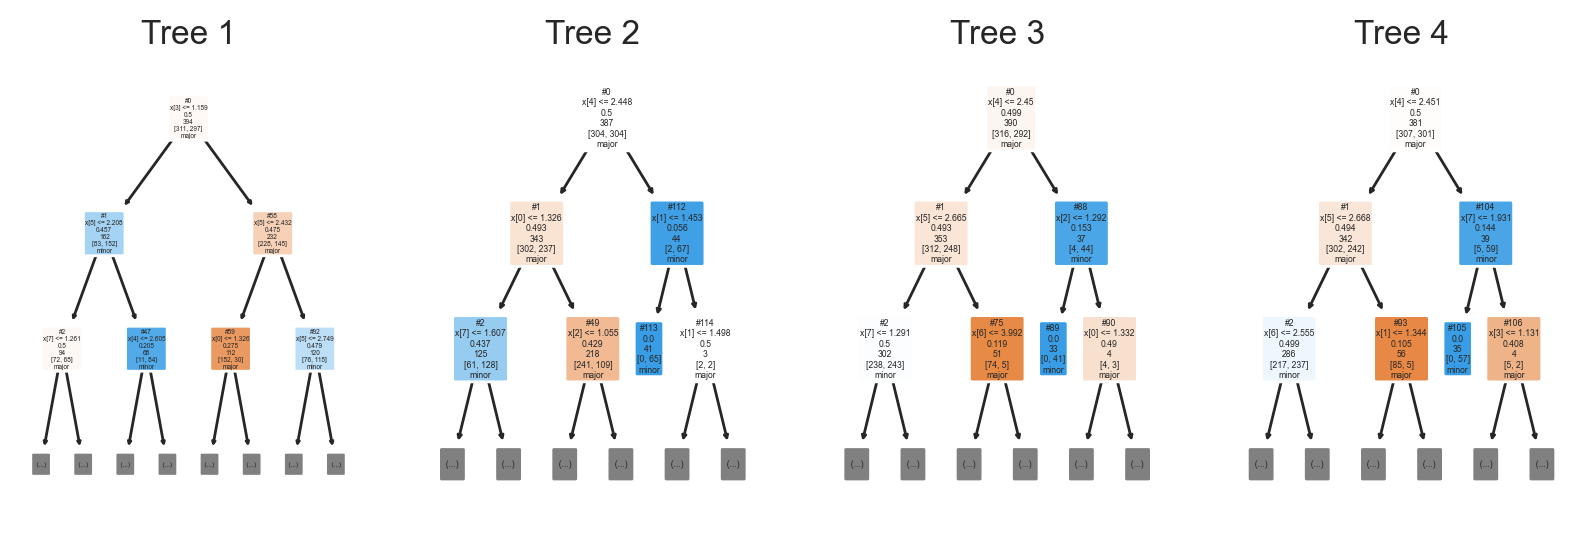

In [62]:
forest_cl = RandomForestClassifier(n_estimators=200, ccp_alpha=0.001, class_weight=None, max_depth=10, max_features=2, max_samples=None, oob_score=True)
forest_cl.fit(X_train, y_train)

fig, axes = plt.subplots(nrows = 1,ncols = 4,figsize = (10,3), dpi=200)

for i in range(4):
  plot_tree(forest_cl.estimators_[i],
            filled=True,
            max_depth=2,
            rounded=True,
            node_ids=True,
            class_names=("major", "minor"),
            ax=axes[i],
            label=None);
  axes[i].set_title("Tree {}".format(i + 1))
fig.show()

<Axes: >

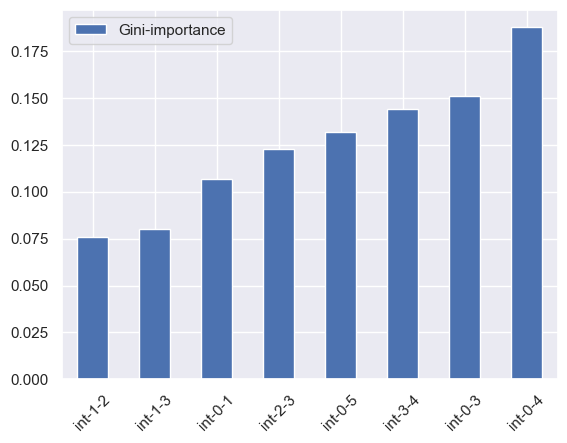

In [63]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_train.columns, forest_cl.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(kind='bar', rot=45)

# Evaluation

In [64]:
print("Tree evaluation report:")
print(classification_report(y_test, forest_cl.predict(X_test), target_names=("major", "minor")))

# Baseline model

print("Baseline model report:")
baseline_pipe
print(classification_report(y_test, baseline_pipe.predict(X_test), target_names=("major", "minor")))

Tree evaluation report:
              precision    recall  f1-score   support

       major       0.92      0.92      0.92       146
       minor       0.94      0.94      0.94       198

    accuracy                           0.93       344
   macro avg       0.93      0.93      0.93       344
weighted avg       0.93      0.93      0.93       344

Baseline model report:
              precision    recall  f1-score   support

       major       0.54      0.64      0.59       146
       minor       0.69      0.60      0.64       198

    accuracy                           0.62       344
   macro avg       0.62      0.62      0.61       344
weighted avg       0.63      0.62      0.62       344



Precision: What portion of positive prediction was actually correct?

- True Positives / (True Positives + False Positives)

Recall: What portion of actual positives were predicted correctly?

- True Positives / (True Positives + False Negatives)

# Summary

When choosing the model three models stood out for us **KNNClassifier**, **DecisionTreeClassifier** and **RandomForestClassifier**. We turned down KNNClassifier, because the model had good results only after we normalized the data. For decision tree and random forest, we had good results even without normalizing the data. Also KNN had overall slightly worse performance than the other two.

After that we decised to use the RandomTreeClassifier. DecisionTreeClassifier showed the same good results, but when we trained multiple models from both the tree classifier and the forest classifier, the forest classifier turned out to be more robust (having good results across all of the folds), where the tree classifier, depending on the random initilazion, had some bad folds.

Created by: Erik Bales, Erik Valcik, Anna Jarosova